# **ECS 7001 - NN & NNLP**

## **Lab 2: LSTM for Text Classification**

<br>

**February 2nd and 3rd**

In Lab 2, you trained word embeddings by casting the unsupervised learning problem as a binary classification problem (i.e. using the skip-gram model). This week, you will build an LSTM model to classify movie reviews as either positive or negative. After training, you will extract the word embeddings learned by the model.



### **0. Prepare the environment**

Open Google Colab or activate the virtual environment you’ve created

### **1. Getting the Dataset**

You will be using the imdb dataset from Lab 0. This is a dataset of 25,000 movie reviews from IMDB, labeled by sentiment - positive (1) or negative (0). 
<br>

The reviews have been preprocessed, and each review is encoded as a list of word indices. Last week, you assigned the indices to the word randomly (or in order of their first appearance in the corpus) but in this preprocessed corpus, the words are indexed by overall frequency in the dataset, such that a word with index 3 occurs more frequently than a word with index 10.
<br>

In the following blocks of code in this section, we will load and visualize the data.


In [ ]:
from tensorflow.keras import datasets

imdb = datasets.imdb

In [ ]:
%%capture

# we'll use the most frequent 10000 words in the vocabulary
VOCAB_SIZE = 10000

# 0 is reserved for ‘<PAD>’, 1 for ‘<START>’ and 2 for ‘<UNK>’ i.e. words not in vocabulary
# the documentation says index_from = 3 but actually uses the value as an offset. The words
# in the dictionary are indexed from 1 by default so, saying index_from=3 means any actual
# words would start from 4 (1+3) and index 3 will be left unused. We use index_from=offset=2 to avoid this
# If you want to explore this further, you may look up the source_code for load_data here
# https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/datasets/imdb.py#L31-L162
OFFSET = 2

# for more information on the load_data method, type(help(load_data))
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=VOCAB_SIZE, index_from=OFFSET)

***Sanity Check***

Each instance in the training data is a list of word indices representing the words in a movie review.

Each label is 1 if that review is positive, else 0.

In [ ]:
print('Sample review:', train_data[0])

Sample review: [1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 2, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 5243, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 2, 7, 3, 106, 116, 5951, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 2, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 7485, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 5534, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11, 15, 282, 4, 15, 4471, 112, 102, 31, 14, 15, 5344, 18, 177, 31]


In [ ]:
print('\n Sample label:', train_labels[0])


 Sample label: 1


### **2. Readying the Inputs for the LSTM**

The movie reviews are of different lengths. The standard way of dealing with varying length inputs is to ***pad*** or ***truncate*** each sentence to a fixed length (which we choose heuristically). 

Keras provides a way to do this.  In this section, you will use the keras.preprocessing.sequence method <pad_sequences> handle padding and truncating.

**Hints**

*  help(pad_sequences) will give you more information about how this works.
*  You can experiment with 'pre' vs 'post' padding/truncating. In practice, 'pre' padding is more effective for our purposes; can you hypothesize about why this is?
*  Since we have reserved 0 for \<PAD\>, your pad value should be set to 0.
*  The maximum length has been specified below as MAX_LENGTH.

In [ ]:
from keras.preprocessing.sequence import pad_sequences


MAX_LENGHT = 500

# YOUR CODE GOES HERE
padded_train_data = pad_sequences(train_data, maxlen=MAX_LENGHT)
padded_test_data = pad_sequences(test_data, maxlen=MAX_LENGHT)

***Sanity Check***

For the first training example, print its length and the padded sequence to see the effect of your padding process. 

PS: Pre-padding was used for the output you see below.

In [ ]:
print('Length of sample train_data before preprocessing:', len(train_data[0]))
print('Length of sample train_data after preprocessing:', len(padded_train_data[0]))
print('Sample train data:', padded_train_data[0])

Length of sample train_data before preprocessing: 218
Length of sample train_data after preprocessing: 500
Sample train data: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  

### **3. Building the Model**

In this section, you will use the keras Model API to build a classification model.

*   The first step is to tell the model what sort of input to expect using the keras \<Input\> layer 
*   The second step is to add an embedding layer like we did last week. 
This embedding layer creates a lookup table of the form {word:embedding} for each of the unique words in our corpus. Use EMBED_SIZE = 100 (i.e each word is represented by a 100D vector such that each movie review is 500 X 100 in dimension.  Don't forget to set mask_zero=True since we are using 0 index as out padding.
*  The third step is to add an LSTM with 100 units. By leaving 'return_sequences' as False, the output of this model will be the output of the final time step of the LSTM. https://keras.io/api/layers/recurrent_layers/lstm/ 
*  The final layer of the model is a fully connected (Dense) layer. Can you figure out what activation function would be appropriate for this layer given the binary nature of the task?
*  The model should be compiled with a 'binary_crossentropy' loss function, an 'adam' optimizer. We also want to visualize the model accuracy during training so the 'metrics' parameter of the compile method should be set to ['accuracy'].

In [ ]:
import tensorflow as tf
from keras.layers import Input, Embedding, Dense, LSTM
from keras.models import Model

EMBED_SIZE = 100

# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
input = Input((500,), dtype='int32')


# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer 
# from whose weights we will get the word embeddings.
embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=500, mask_zero=True)(input)



lstm = tf.keras.layers.LSTM(100, return_sequences=False)(embedding)

output1 = Dense(1, activation='relu')(lstm)
output2 = Dense(1, activation='sigmoid')(lstm)
output3 = Dense(1, activation='softmax')(lstm)

model1 = Model(inputs=[input], outputs=[output1])
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model2 = Model(inputs=[input], outputs=[output2])
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model3 = Model(inputs=[input], outputs=[output3])
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


***Sanity Check***

Print the model summary and visualize it using vis_utils.

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 target_embed_layer (Embeddi  (None, 500, 100)         1000000   
 ng)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


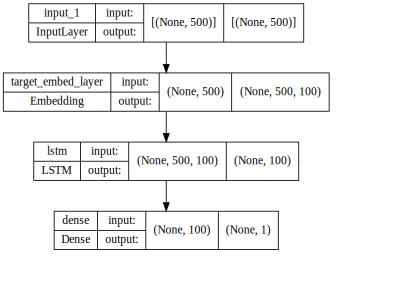

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model1, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  


### **4. Training the Model**

A model can memorize the training data (this is called 'overfitting' and when it does so, it's training accuracy can continue to go up but it's accuracy on previously unseen (i.e. non-training) examples can be very poor. To ensure that this doesn't happen, researchers often intermittently check the performance of a model being trained on a held back dataset called the ***validation dataset***. This way, 'early stopping' or 'random search' can be used to select the model that will generalize best to unseen data. 
<br>


In this lab, you will just plot training accuracy against validation accuracy to monitor the progress of your model. And, using the plot, you will theorize about what the optimal stopping point for your model should have been.


**Step 1: Getting a validation dataset**

Before we begin training, you will split the padded training data into training and validation data. To avoid losing too much training data, use 2000 samples (i.e 8%) for validation and the other 23000 for training.

We will do this using the sklearn train_test_split function. 

In [ ]:
from sklearn.model_selection import train_test_split

train_x, validation_x, train_y, validation_y = train_test_split(padded_train_data, train_labels, test_size=0.08) 

Alternatively, we could have chosen to set validation_size=0.08 in our model.fit() function below instead of passing in a separate validation dataset.

**Step 2: Training the model**

We will use model.fit() to train the model. We will set our batch_size to 1000, which means the model will train int(23000/1000) batches each epoch. In other words, at each epoch the model will train 23 batches, each one consisting of 1000 movie reviews.

In [ ]:
history1 = model1.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 21s 634ms/step - loss: 1.2687 - accuracy: 0.5075 - val_loss: 0.7739 - val_accuracy: 0.5035
Epoch 2/6
23/23 [==============================] - 14s 598ms/step - loss: 0.8042 - accuracy: 0.4997 - val_loss: 0.7598 - val_accuracy: 0.5035
Epoch 3/6
23/23 [==============================] - 14s 598ms/step - loss: 0.6698 - accuracy: 0.5603 - val_loss: 0.6232 - val_accuracy: 0.7370
Epoch 4/6
23/23 [==============================] - 15s 639ms/step - loss: 0.5773 - accuracy: 0.7311 - val_loss: 0.5773 - val_accuracy: 0.7340
Epoch 5/6
23/23 [==============================] - 16s 678ms/step - loss: 0.5001 - accuracy: 0.7891 - val_loss: 0.4949 - val_accuracy: 0.7645
Epoch 6/6
23/23 [==============================] - 14s 608ms/step - loss: 0.4635 - accuracy: 0.8305 - val_loss: 0.5471 - val_accuracy: 0.7390


In [ ]:
history2 = model2.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 39s 2s/step - loss: 0.6392 - accuracy: 0.6491 - val_loss: 0.5590 - val_accuracy: 0.7575
Epoch 2/6
23/23 [==============================] - 25s 1s/step - loss: 0.4180 - accuracy: 0.8334 - val_loss: 0.3507 - val_accuracy: 0.8530
Epoch 3/6
23/23 [==============================] - 23s 987ms/step - loss: 0.2725 - accuracy: 0.8943 - val_loss: 0.2922 - val_accuracy: 0.8810
Epoch 4/6
23/23 [==============================] - 23s 1s/step - loss: 0.1995 - accuracy: 0.9277 - val_loss: 0.2818 - val_accuracy: 0.8855
Epoch 5/6
23/23 [==============================] - 24s 1s/step - loss: 0.1569 - accuracy: 0.9475 - val_loss: 0.2887 - val_accuracy: 0.8860
Epoch 6/6
23/23 [==============================] - 23s 998ms/step - loss: 0.1282 - accuracy: 0.9602 - val_loss: 0.3284 - val_accuracy: 0.8785


In [ ]:

history3 = model3.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 19s 722ms/step - loss: 0.2645 - accuracy: 0.5003 - val_loss: 0.3244 - val_accuracy: 0.4965
Epoch 2/6
23/23 [==============================] - 14s 610ms/step - loss: 0.1335 - accuracy: 0.5003 - val_loss: 0.3417 - val_accuracy: 0.4965
Epoch 3/6
23/23 [==============================] - 14s 615ms/step - loss: 0.1119 - accuracy: 0.5003 - val_loss: 0.3464 - val_accuracy: 0.4965
Epoch 4/6
23/23 [==============================] - 14s 609ms/step - loss: 0.1006 - accuracy: 0.5003 - val_loss: 0.3526 - val_accuracy: 0.4965
Epoch 5/6
23/23 [==============================] - 14s 603ms/step - loss: 0.0912 - accuracy: 0.5003 - val_loss: 0.3812 - val_accuracy: 0.4965
Epoch 6/6
23/23 [==============================] - 15s 647ms/step - loss: 0.0794 - accuracy: 0.5003 - val_loss: 0.4013 - val_accuracy: 0.4965


**Step 3: Visualize the model plot**

In [ ]:
pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.30-py3-none-any.whl size=8794 sha256=239158d14869c210d92834ae2bbb316cf056defe1ca4bc6eb124dfc9ecb7fe26
  Stored in directory: /root/.cache/pip/wheels/b0/60/47/8c5aa37c06be5e97879ec467bc2e6a30b315d95f662c63a503
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.29-py3-none-any.whl size=7878 sha256=a26b4323cbb78a4f4437c3c381e1c27d4cbb0e34d723080d4aff760ce94a532e
  Stored in directory: /root/.cache/pip/wheels/c2/f5/71/d1c459da10abec864a1979b449edbf37d4a82ab3e38a3625a8
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4588 sha256=ffa9310117088bf8c055b33a4ed5bb1a06d494413190096d9a7be0513cfd0d44
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

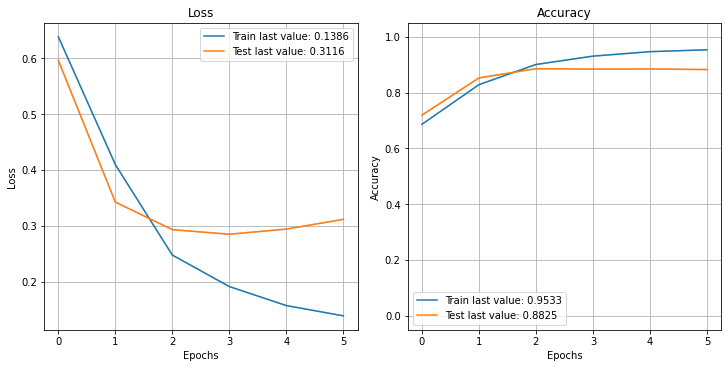

In [ ]:
plot_history(history2.history, path="standard.png")
plt.show()

**Based on the accuracy plot, what do you think the optimal stopping point for your model should
have been?**

The optimal stopping point for this model is the point where the loss curve starts increasing. In the loss vs epochs graph, the loss curve keeps on decreasing till the 4th epoch (loss is minimum at 4th epoch). Thereafter, in the 5th and the 6th epochs the loss starts increasing  hence the optimal point for the model to stop is the 4th epoch (denoted by 3 on the x axis).

### **5. Evaluating the Model on the Test Data**

Evaluate the model on the padded test data using the code in the following cell block.

In [ ]:
# YOUR CODE TO EVALUATE THE MODEL ON TEST DATA GOES HERE

results = model2.evaluate(padded_test_data, test_labels)
print('test_loss:', results[0], 'test_accuracy:', results[1])

782/782 [==============================] - 79s 99ms/step - loss: 0.3758 - accuracy: 0.8562
test_loss: 0.37576133012771606 test_accuracy: 0.8561599850654602


###**6. Extracting the Word Embeddings**

Extract the word embeddings from the embedding layer model like we did in the last lab. 

**Hints**

*  You can use model.get_layer(layer_name).get_weights()[0] or model.layers[layer_number].get_weights()[0].  The layer number indicates the order in which the layers were added to the model.

*  If you didn't explicitly name your layers, you can check layer names and numbers about the order from model.summary() or by calling model.layers

In [ ]:
# YOUR CODE GOES HERE

word_embeddings = model2.get_layer('target_embed_layer').get_weights()[0] 

In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 target_embed_layer (Embeddi  (None, 500, 100)         1000000   
 ng)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


***Sanity Check***

Print the shape of the word embeddings using the line of code below. It should return (VOCAB_SIZE, EMBED_SIZE)

In [ ]:
print('Shape of word_embeddings:', word_embeddings.shape)

Shape of word_embeddings: (10000, 100)


###**7. Visualizing the Reviews**

In this section, we will view the effects of padding the dataset. 

As mentioned before, Keras already preprocessed the corpus. In this preprocessed corpus, all the words have already been mapped to indices and were assigned these numbers in order of their frequency such that index 2 is the 2nd most frequent word in the dataset, and so on. However, when we loaded our training dataset, we reserved the first 3 indices - 0, 1, 2 - for \<PAD\>, \<START\> and \<UNK\>. Additionally, we limited our vocabulary to only the top 10000 most frequent words (9997 if you exclude the padding). We will now visualize what a movie review will look like with these changes




**Step 1: Create a word2idx dictionary**

Create the word2idx dictionary using the following lines of code.

In [ ]:
# in this dictionary, the words start from 1, 0 is reserved for padding but 
# <start> and <unknown> are not accounted for.
word_indices = imdb.get_word_index()

# so we shift each original word two places to make room for the two new tokens
offset = 2
word2idx = {k:(v+offset) for k,v in word_indices.items() if v < 9998}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2

1654784/1641221 [==============================] - 0s 0us/step



**Step 2: Create a the idx2word dictionary**

In [ ]:
# YOUR CODE GOES HERE
idx2word = {idx: words for words, idx in word2idx.items()}


**Step 3: Visualize sample review**

View a sample review text using the lines of code below:

In [ ]:
print(' '.join(idx2word[idx] for idx in train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

###**8. Visualizing the Word_Embeddings**

Visualize the word embeddings for 10 of the words using pandas DataFrame like we did in lab 3

In [ ]:
# YOUR CODE GOES HERE
import pandas as pd
from pandas import DataFrame
from IPython.display import display
pd.options.display.max_columns = 10
display(DataFrame(word_embeddings, index=idx2word.values()).head(10))

,0,1,2,3,4,...,95,96,97,98,99
woods,-0.000117,0.017946,-0.011185,-0.007713,-0.023812,...,0.003199,-0.001018,-0.001056,-0.015582,-0.004548
hanging,0.011235,0.006468,-0.017000,0.019055,-0.010947,...,-0.008040,0.020040,-0.018575,0.022410,-0.013473
woody,-0.004363,0.008289,0.000364,0.021613,-0.010972,...,-0.017974,0.020363,0.018588,0.006957,-0.006794
arranged,-0.006906,0.010869,-0.002573,-0.020614,0.006199,...,-0.009147,0.016082,-0.009247,-0.014889,-0.028392
bringing,0.013023,-0.001899,0.007824,0.015944,-0.011302,...,-0.022724,-0.006283,0.009416,0.001611,-0.001124
wooden,0.009313,-0.011699,0.015990,0.012871,0.006262,...,0.005189,-0.012286,-0.000245,-0.016668,-0.012613
errors,-0.007666,-0.020862,0.028455,-0.021285,0.006857,...,0.024257,-0.019767,-0.004810,0.008680,0.014081
dialogs,-0.015788,-0.006587,0.005321,0.019739,-0.014691,...,0.002277,-0.000943,-0.001521,-0.002772,-0.013544
kids,-0.022068,-0.013539,0.015680,-0.004567,0.006598,...,-0.002620,-0.004581,-0.005351,-0.016945,-0.019037
uplifting,-0.014509,-0.024773,0.032108,-0.001215,-0.015602,...,0.000304,-0.019513,0.016988,-0.030919,-0.024130


###**9. Plot your Word Embeddings using t-SNE**


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


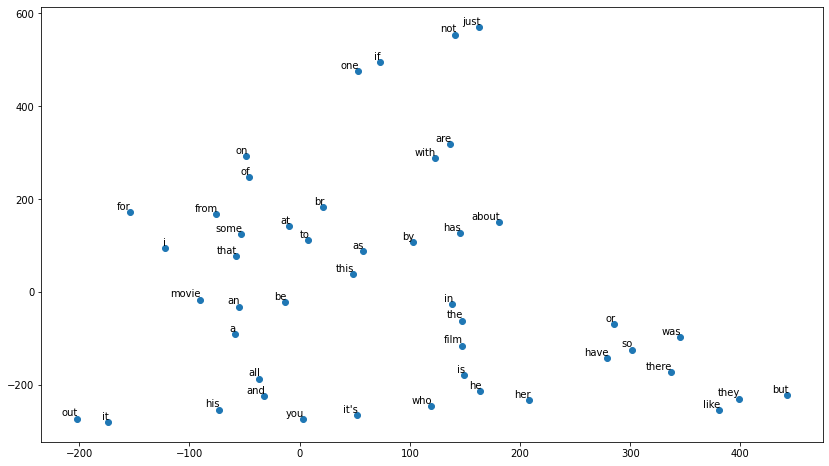

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50

# don't plot the special tokens
start = 3
T = tsne.fit_transform(word_embeddings[start:plot_only, :])
labels = [idx2word[i] for i in range(start, plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        


###**10. Questions**

1. Create a new model that is a copy of the model step 3. To this new model,add two dropout layers, one between the embedding layer and the LSTM layer and another between the LSTM layer and the output layer. Repeat steps 4 and 5 for this model. What do you observe?

2. Experiment with training the model with batch sizes of 1, 32, len(training_data). What do you observe?

3. (optional) Can you retrain with a Bidirectional LSTM instead of an LSTM? What do you observe about the Bi-LSTM model?


Question 1

In [ ]:
import tensorflow as tf
from keras.layers import Input, Embedding, Dense, LSTM, Dropout
from keras.models import Model

EMBED_SIZE = 100

# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
input = Input((500,), dtype='int32')


# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer 
# from whose weights we will get the word embeddings.
embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=500, mask_zero=True)(input)
dp1 = Dropout(0.2)(embedding)
dp1_2 = Dropout(0.3)(embedding)

lstm = tf.keras.layers.LSTM(100, return_sequences=False)(dp1)
lstm2 = tf.keras.layers.LSTM(100, return_sequences=False)(dp1_2)

dp2 = Dropout(0.2)(lstm)
dp2_2 = Dropout(0.3)(lstm2) 


outputq1 = Dense(1, activation='sigmoid')(dp2)  #using sigmoid as it had best accuracy when tested previously
outputq1_2 =  Dense(1, activation='sigmoid')(dp2_2)

modelq1 = Model(inputs=[input], outputs=[outputq1])
modelq1_2 = Model(inputs=[input], outputs=[outputq1_2])  # another model with drop (0.3)

modelq1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelq1_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
modelq1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 500)]             0         
                                                                 
 target_embed_layer (Embeddi  (None, 500, 100)         1000000   
 ng)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 500, 100)          0         
                                                                 
 lstm_4 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                           

In [ ]:
modelq1_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 target_embed_layer (Embeddi  (None, 500, 100)         1000000   
 ng)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 500, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                           

In [ ]:
historyq1 = modelq1.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 15s 645ms/step - loss: 0.2160 - accuracy: 0.9180 - val_loss: 0.3728 - val_accuracy: 0.8375
Epoch 2/6
23/23 [==============================] - 15s 628ms/step - loss: 0.1674 - accuracy: 0.9417 - val_loss: 0.3333 - val_accuracy: 0.8780
Epoch 3/6
23/23 [==============================] - 14s 625ms/step - loss: 0.1196 - accuracy: 0.9618 - val_loss: 0.3561 - val_accuracy: 0.8850
Epoch 4/6
23/23 [==============================] - 14s 625ms/step - loss: 0.0980 - accuracy: 0.9709 - val_loss: 0.3563 - val_accuracy: 0.8805
Epoch 5/6
23/23 [==============================] - 15s 640ms/step - loss: 0.0823 - accuracy: 0.9785 - val_loss: 0.3990 - val_accuracy: 0.8830
Epoch 6/6
23/23 [==============================] - 15s 638ms/step - loss: 0.0706 - accuracy: 0.9827 - val_loss: 0.3975 - val_accuracy: 0.8775


In [ ]:
historyq1_2 = modelq1_2.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 37s 1s/step - loss: 0.6392 - accuracy: 0.6509 - val_loss: 0.4862 - val_accuracy: 0.7785
Epoch 2/6
23/23 [==============================] - 23s 1000ms/step - loss: 0.3517 - accuracy: 0.8613 - val_loss: 0.3045 - val_accuracy: 0.8800
Epoch 3/6
23/23 [==============================] - 26s 1s/step - loss: 0.2316 - accuracy: 0.9138 - val_loss: 0.2693 - val_accuracy: 0.8885
Epoch 4/6
23/23 [==============================] - 29s 1s/step - loss: 0.1739 - accuracy: 0.9407 - val_loss: 0.2738 - val_accuracy: 0.8855
Epoch 5/6
23/23 [==============================] - 23s 1s/step - loss: 0.1417 - accuracy: 0.9527 - val_loss: 0.3216 - val_accuracy: 0.8675
Epoch 6/6
23/23 [==============================] - 23s 1s/step - loss: 0.1619 - accuracy: 0.9442 - val_loss: 0.3342 - val_accuracy: 0.8770


In [ ]:
# YOUR CODE TO EVALUATE THE MODEL ON TEST DATA GOES HERE

resultsq1 = modelq1.evaluate(padded_test_data, test_labels)
print('test_loss:', resultsq1[0], 'test_accuracy:', resultsq1[1])

782/782 [==============================] - 64s 81ms/step - loss: 0.4393 - accuracy: 0.8606
test_loss: 0.43934616446495056 test_accuracy: 0.8605599999427795


In [ ]:
resultsq1_2 = modelq1_2.evaluate(padded_test_data, test_labels)
print('test_loss:', resultsq1_2[0], 'test_accuracy:', resultsq1_2[1])

782/782 [==============================] - 102s 130ms/step - loss: 0.3711 - accuracy: 0.8589
test_loss: 0.3710888624191284 test_accuracy: 0.8589199781417847


## Adding two droput layer have incresaed our test dat aaccuracy by a very small margin. 85.6-->86 (with dropout (0.2) whereas 85.6 to 85.89 (with dropout (0.3))

Question 2

In [ ]:
historyq1x = modelq1.fit(train_x[:300], train_y[:300], epochs=6, batch_size=1, validation_data=(validation_x[:300], validation_y[:300]))

Epoch 1/6
300/300 [==============================] - 285s 952ms/step - loss: 0.1413 - accuracy: 0.9533 - val_loss: 0.9668 - val_accuracy: 0.6833
Epoch 2/6
300/300 [==============================] - 278s 927ms/step - loss: 0.0349 - accuracy: 0.9900 - val_loss: 0.9086 - val_accuracy: 0.7167
Epoch 3/6
300/300 [==============================] - 278s 925ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.0628 - val_accuracy: 0.7100
Epoch 4/6
300/300 [==============================] - 277s 924ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.2721 - val_accuracy: 0.7267
Epoch 5/6
300/300 [==============================] - 277s 925ms/step - loss: 4.9143e-04 - accuracy: 1.0000 - val_loss: 1.2685 - val_accuracy: 0.7233
Epoch 6/6
300/300 [==============================] - 316s 1s/step - loss: 2.8629e-04 - accuracy: 1.0000 - val_loss: 1.3684 - val_accuracy: 0.7267


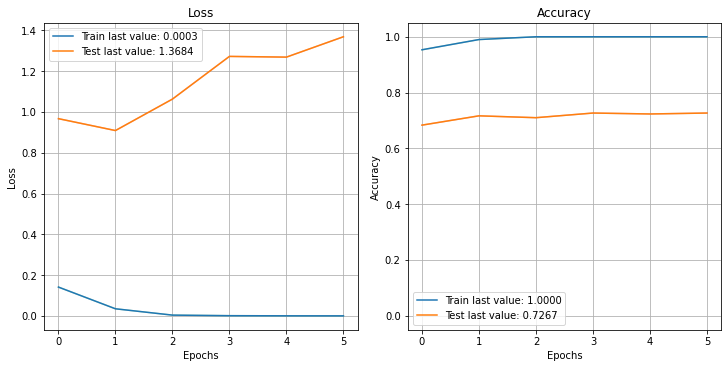

In [ ]:
plot_history(historyq1x.history, path="standard.png")
plt.show()

In [ ]:
historyq1y = modelq1.fit(train_x[:300], train_y[:300], epochs=6, batch_size=32, validation_data=(validation_x[:300], validation_y[:300]))

Epoch 1/6
10/10 [==============================] - 27s 2s/step - loss: 0.5411 - accuracy: 0.7367 - val_loss: 0.5857 - val_accuracy: 0.7033
Epoch 2/6
10/10 [==============================] - 45s 5s/step - loss: 0.4950 - accuracy: 0.7900 - val_loss: 0.5812 - val_accuracy: 0.7067
Epoch 3/6
10/10 [==============================] - 22s 2s/step - loss: 0.4477 - accuracy: 0.8233 - val_loss: 0.5762 - val_accuracy: 0.7067
Epoch 4/6
10/10 [==============================] - 22s 2s/step - loss: 0.4014 - accuracy: 0.8600 - val_loss: 0.5708 - val_accuracy: 0.7200
Epoch 5/6
10/10 [==============================] - 22s 2s/step - loss: 0.3432 - accuracy: 0.9067 - val_loss: 0.5647 - val_accuracy: 0.7200
Epoch 6/6
10/10 [==============================] - 23s 2s/step - loss: 0.2909 - accuracy: 0.9367 - val_loss: 0.5580 - val_accuracy: 0.7300


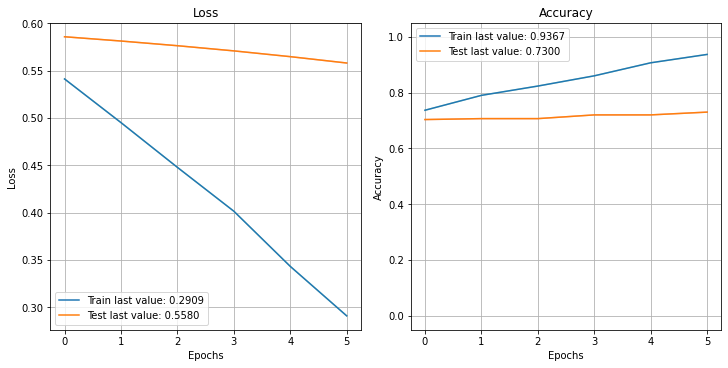

In [ ]:
plot_history(historyq1y.history, path="standard.png")
plt.show()

In [ ]:
historyq1z = modelq1.fit(train_x[:300], train_y[:300], epochs=6, batch_size=len(train_x), validation_data=(validation_x[:300], validation_y[:300]))


Epoch 1/6
1/1 [==============================] - 2s 2s/step - loss: 0.2171 - accuracy: 0.9667 - val_loss: 0.5518 - val_accuracy: 0.7267
Epoch 2/6
1/1 [==============================] - 2s 2s/step - loss: 0.2071 - accuracy: 0.9633 - val_loss: 0.5507 - val_accuracy: 0.7233
Epoch 3/6
1/1 [==============================] - 2s 2s/step - loss: 0.2027 - accuracy: 0.9700 - val_loss: 0.5496 - val_accuracy: 0.7233
Epoch 4/6
1/1 [==============================] - 2s 2s/step - loss: 0.1935 - accuracy: 0.9667 - val_loss: 0.5485 - val_accuracy: 0.7267
Epoch 5/6
1/1 [==============================] - 2s 2s/step - loss: 0.1897 - accuracy: 0.9667 - val_loss: 0.5473 - val_accuracy: 0.7267
Epoch 6/6
1/1 [==============================] - 2s 2s/step - loss: 0.1806 - accuracy: 0.9700 - val_loss: 0.5461 - val_accuracy: 0.7267


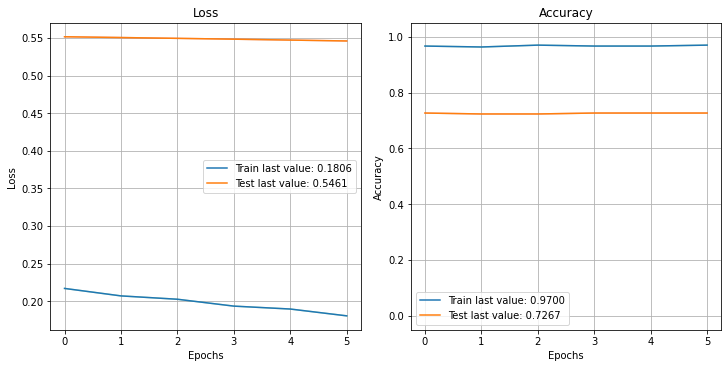

In [ ]:
plot_history(historyq1z.history, path="standard.png")
plt.show()

****Observations included in the report****
